# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 мая 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 мая, -4 балла после 06:00 13 мая, -6 баллов после 06:00 20 мая -8 баллов  после 06:00 27 мая


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [3]:
import re
import time
import pandas as pd
import pylab as pl
import numpy as np
import pymorphy2
import scipy.spatial as ss
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

import time
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



$$Вопрос\ 1$$

$$Пусть\ Q\ -\ это\ потери \ на\ шаге\ E,\ тогда\ Q_r \ -\ это\ потери,\ после\ того \ как \ мы \ оптимизировали \ функцию \ потерь\ по \ переменной\ r $$

$$ Тогда\ Q_r <= Q $$

$$ Теперь \ рассмотрим \ функцию\  потерь\  для \ каждого  \ отдельного \ класса,\ так\ точки\ в\ этих\ классах\ независимы,\ то\ сумма\ минимумов\ будет\ равна\ минимуму\ суммы$$ 

$$ Q_k = \sum_{x_i \in K}(||x_i - M_k||^2) $$

$$ где\ K\ -\ множество\ всех\ элементов,\ относящихся\ к \ кластеру\ k $$
$$ M_k\ -\ центр\ кластера\ k $$

$$ Но \ это \ уравнение \ параболы, у \ которой \ ветви \ направлены \ вверх, \ следовательно, \ минимум \ данной \ функции\ находится \ в \ вершине \ параболы \ т.е.  $$

$$ M_k = \frac{\sum(x_i)}{N_k} $$
$$ где\ N_k\ -\ количество\ элементов\ в \ классе\ k  $$

$$ т.е.\ элемент\ последовательность\ значений\ функции\ потерь\ на\ каждом\ шаге\ не\ больше\ предыдущего\ сл-но,\ по \ теореме\ Вейерштрасса\ последовательность\ сходится\ $$


$$ Вопрос\ 2 $$
$$ У\ нас\ существует\ k^N\ способов\ распределить\ все\ точки\ по \ k \ кластерам $$
$$ Если\ на\ двух\ подряд\ идущих\ итерациях\ совпадают\ значения\ функции\ потерь,\ то\ следующая\ итерация \ будет\ такой\ же $$
$$ Если\ у\ нас \ совпали\ значения\ на\ двух\ итерациях,\ то\ значения\ функции\ потерь\ тоже\ должны\ совпасть,\ но\ так\ как\ на\ каждом\ шаге\ значение\ функции\ потерь\ не\ увеличивается,\ то\ все\ промежуточные\ значения\ функции\ потерь\ тоже\ совпадают\ -\ противоречие,\ так\ как\ на\ них\ мы\ бы\ уже\ остановились,\ а\ по\ факту\ мы\ пошли\ дальше\$$
$ Сл-но, \ все \ наборы \ различны, \ сл-но, \ их\ количество\ не \ превосходит\ k^N $

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ответ***

Здесь все происходит аналогично, мы хотим максимизировать правдоподобие, и для этого максимизируем ее нижнюю оценку - L, на каждом шаге E и M L не убывает и ограничена сверху 0, так как вероятность ограничена сверху 1, а логарифм от 1 = 0, сл-но, по теореме Вейерштрасса функция сходится. 

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ответ***

***Первая формула это просто $$ \min(d_{min}(U, S),d_{\min}(V, S))$$***
***Когда мы объединяем два класса, то в итоге минимальное расстояние будет равно рассточнию между двумя точками, одна из которых принадлежит либо классу U, либо классу V.***
***Вторая формула аналогично***

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [116]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """

    def __init__(self, metric, linkage='single', n_clasters=2, **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.metric = metric
        self.n_clasters = n_clasters
        self.linkage = linkage
        self.ind = 0
        self.dend_info = np.array([])
        self.max_cl = 0
        return

    def distance(self, a, b):
        if self.metric == 'euclidian':
            a = np.array(a)
            b = np.array(b)
            return np.sqrt(np.sum((a - b) ** 2))

        if self.metric == 'cosine':
            a = np.array(a)
            b = np.array(b)
            t = np.dot(a, b.T)
            p = sqrt((a ** 2).sum()) * sqrt((b ** 2).sum())
            if t / p > 1:
                return 0
            return np.arccos(t / p)

        if self.metric == 'number_of_words':
            n = len(np.unique(a + b))
            a = np.unique(a)
            sc = 0
            for i in a:
                if i in b:
                    sc += 1
            return 1 - sc / n
        pass

    def find_min(self, graph, tree):
        k = len(graph)
        min_ = np.array([0, 0, -1])
        for i in range(k):
            for j in range(i + 1, k):
                if (min_[2] > graph[i][j] or min_[2] == -1) and tree[i] != tree[j]:
                    min_ = np.array([i, j, graph[i][j]])
        return min_

    def update_graph(self, graph, tree, x, y):
        c = [0, 0, 0]
        x = int(x)
        y = int(y)
        tree_x = np.array(graph[x])
        tree_y = np.array(graph[y])
        k = len(graph)
        if self.linkage == 'single':
            c = [1 / 2, 1 / 2, -1 / 2]
        if self.linkage == 'complete':
            c = [1 / 2, 1 / 2, 1 / 2]
        if self.linkage == 'average':
            for i in tree:
                if i == tree[x]:
                    c[0] += 1
                if i == tree[y]:
                    c[1] += 1
            c[2] = c[0] + c[1]
            c[0] = c[0] / c[2]
            c[1] = c[1] / c[2]
            c[2] = 0
        for i in range(k):
            if tree[i] in [tree[x], tree[y]]:
                for j in range(k):
                    tmp = c[0] * tree_x[j] + c[1] * tree_y[j] + c[2] * abs(tree_x[j] - tree_y[j])
                    graph[j][i] = graph[i][j] = tmp
        return graph

    def update_tree(self, tree, a, b):
        self.max_cl += 1
        tmp = np.zeros(len(tree))
        for i in range(len(tree)):
            tmp[i] = tree[i]
            if tree[i] in [tree[int(b)], tree[int(a)]]:
                tmp[i] = self.max_cl
        return tmp

    def number_repr(self, tree, claster):
        number_repr = 0
        for i in tree:
            if i == claster:
                number_repr += 1
        return number_repr

    def build_tree(self, x):

        k = len(x)
        self.max_cl = k - 1
        tree = np.arange(0, k ** 2).reshape(k, k)
        graph = np.zeros((k, k))
        for i in range(k):
            for j in range(k):
                graph[i][j] = graph[j][i] = self.distance(x[i], x[j])

        for i in range(1, k):
            min_ = self.find_min(graph, tree[i - 1])
            old_x = tree[i - 1][int(min_[0])]
            old_y = tree[i - 1][int(min_[1])]
            tree[i] = self.update_tree(tree[i - 1], min_[0], min_[1])
            graph = self.update_graph(graph, tree[i - 1], min_[0], min_[1])
            min_ = np.append(min_, self.number_repr(tree[i], tree[i][int(min_[0])]))
            min_[0] = old_x
            min_[1] = old_y
            self.dend_info = np.append(self.dend_info, min_)
        '''
        for i in tree:
            print(i)
        '''
        self.dend_info = self.dend_info.reshape(-1, 4)
        self.tree = tree
        return tree[k - self.n_clasters]

    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        return self.build_tree(x)

    def cut_tree(self, height):
        i = 0
        while (i < len(self.dend_info)) and (self.dend_info[i][2] < height):
            i += 1
        return self.tree[i]

    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig.set_figheight(10)
        fig.set_figwidth(20)
        hierarchy.dendrogram(self.dend_info)
        pass


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

In [74]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

<Figure size 720x360 with 0 Axes>

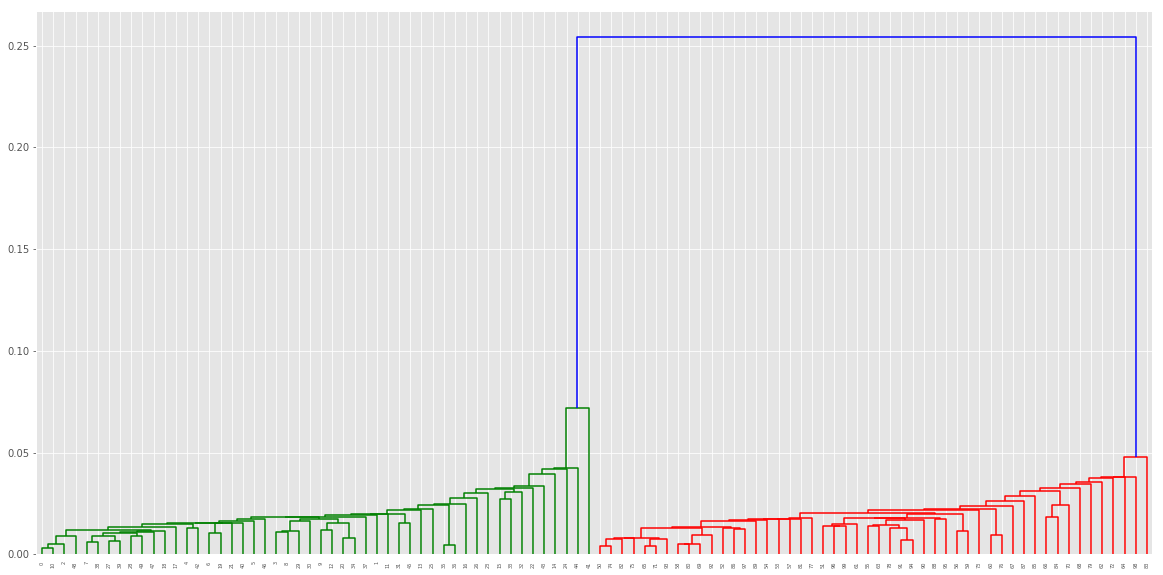

In [76]:
pl.figure(figsize=(10, 5))
myclf = Clustering('cosine', 'single', 2)
t = myclf.fit_predict(x_iris)
myclf.plot_dendrogram()
plt.show()


<Figure size 720x360 with 0 Axes>

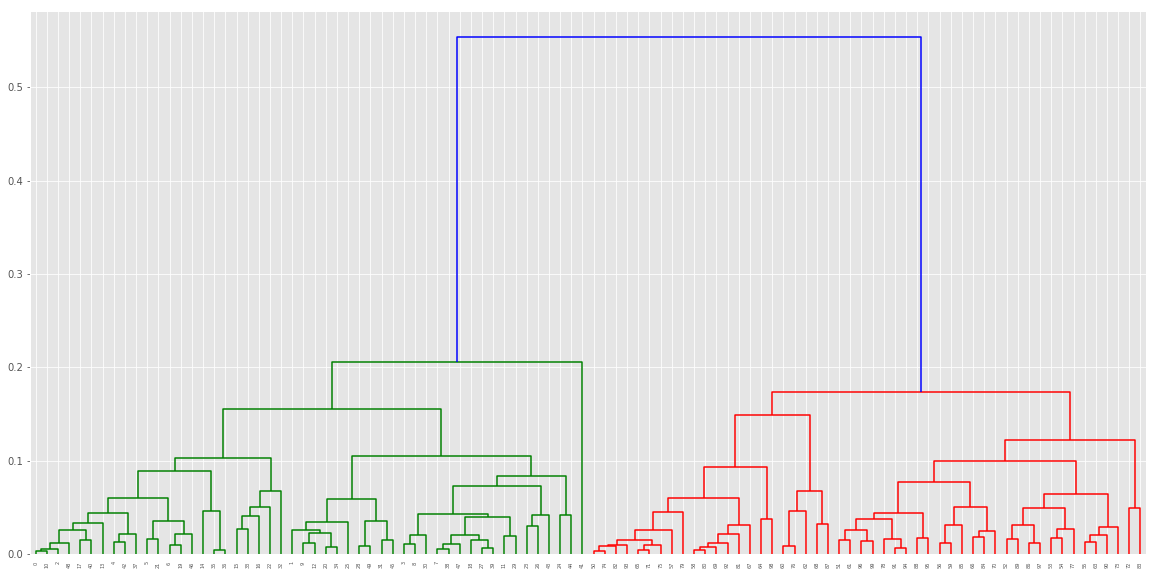

In [15]:
pl.figure(figsize=(10, 5))
myclf = Clustering('cosine', 'complete', 2)
t = myclf.fit_predict(x_iris)
t.shape
myclf.plot_dendrogram()
plt.show()

<Figure size 720x360 with 0 Axes>

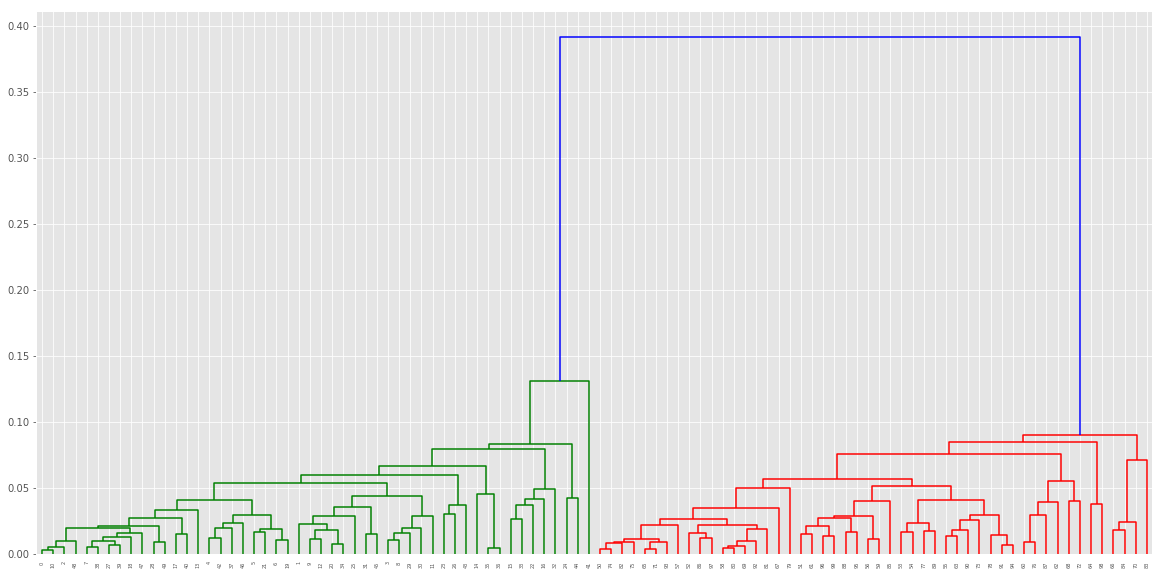

In [16]:
pl.figure(figsize=(10, 5))
myclf = Clustering('cosine', 'average', 2)
t = myclf.fit_predict(x_iris)
t.shape
myclf.plot_dendrogram()
plt.show()

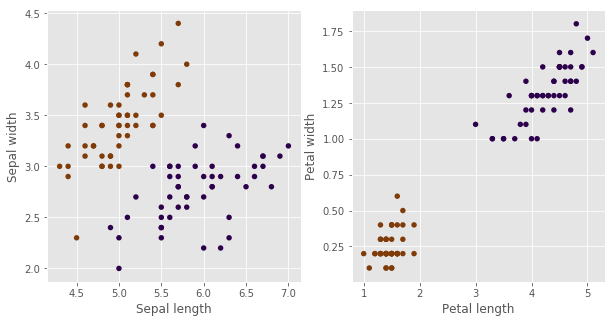

In [17]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [18]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.015466690063476562


In [19]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='euclidian', n_clusters=2)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 1.6578521728515625


# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

***Ответы***
1)Посмотреть на кластеры, которые добавляются в самом конце, они и будут аномалиями.

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках. В семинаре мы рассматривали более сложный вариант, но Вы сможете придумать лучше. 

In [20]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title

In [21]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять например словами из тайтла

Главное подобрать хорошую функцию расстояния между документами

Удачи! Все получится!

Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [48]:
def make_dict(doc_id, doc_to_title, tokenizer):
    array = []
    for i in doc_id:
        sent = doc_to_title[i]
        array.append(' '.join(list(tokenizer(sent))))
    return array


def make_vector(doc_id, doc_to_title, vectorizer):
    tokenizer = vectorizer.build_tokenizer()
    dict_ = make_dict(df.doc_id, doc_to_title, tokenizer)
    vectorizer.fit(dict_)
    vectors = []
    for i in doc_id:
        sent = doc_to_title[i]
        vectors.append(sent)
    vectors = vectorizer.transform(vectors).todense()
    return vectors


def make_sentence_vectors(doc_id, doc_to_title, vectorizer):
    tokenizer = vectorizer.build_tokenizer()
    dict_ = make_dict(df.doc_id, doc_to_title, tokenizer)
    result = []
    for i in dict_:
        result.append(i.split())
    return result


f1_score = 0.6086956521739131


,target,predict
196,0,0
197,0,0
198,1,1
199,0,0
200,0,0
201,0,0
202,0,0
203,0,0
204,0,0
205,0,0


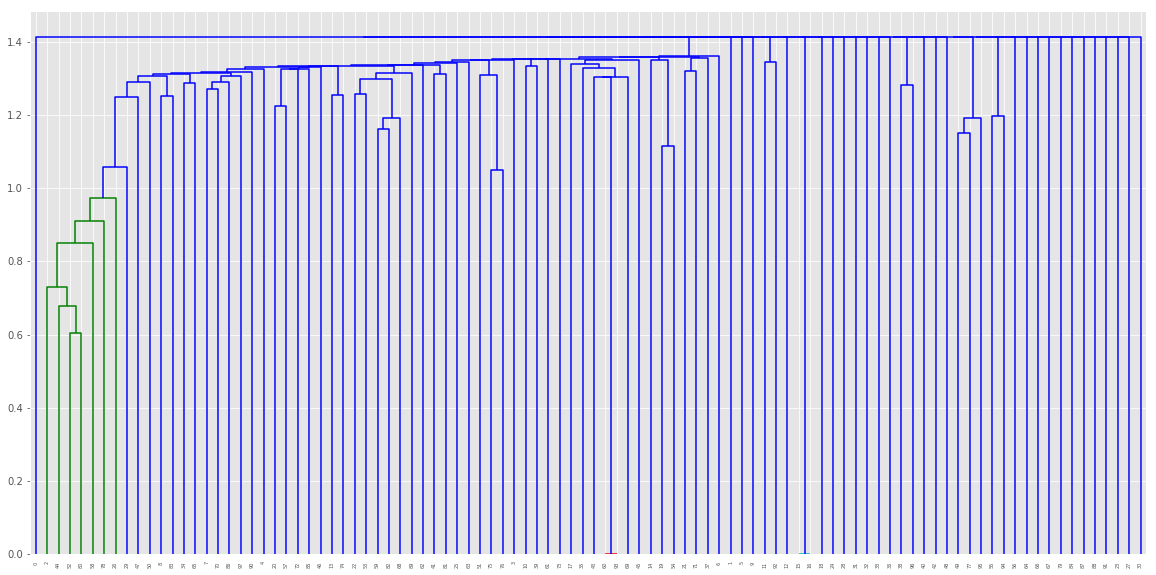

In [78]:
morph = pymorphy2.MorphAnalyzer()
vectorizer = TfidfVectorizer()

df = train_data[train_data.group_id == 3][['doc_id', 'target']]
X = make_vector(df.doc_id, doc_to_title, vectorizer)
myclf = Clustering('euclidian', 'single', 2)
t = myclf.fit_predict(X)
cl = myclf.cut_tree(1.1)
k = len(cl)
for j in range(k):
    if cl[j] < k:
        cl[j] = 0
    else:
        cl[j] = 1
print('f1_score =', smt.f1_score(df.target, cl))
results = pd.DataFrame({
    'target': df.target,
    'predict': cl
})
pd.set_option('display.max_rows', 100)
myclf.plot_dendrogram()
results


f1_score = 0.6


,target,predict
196,0,0
197,0,0
198,1,1
199,0,0
200,0,0
201,0,0
202,0,0
203,0,0
204,0,0
205,0,0


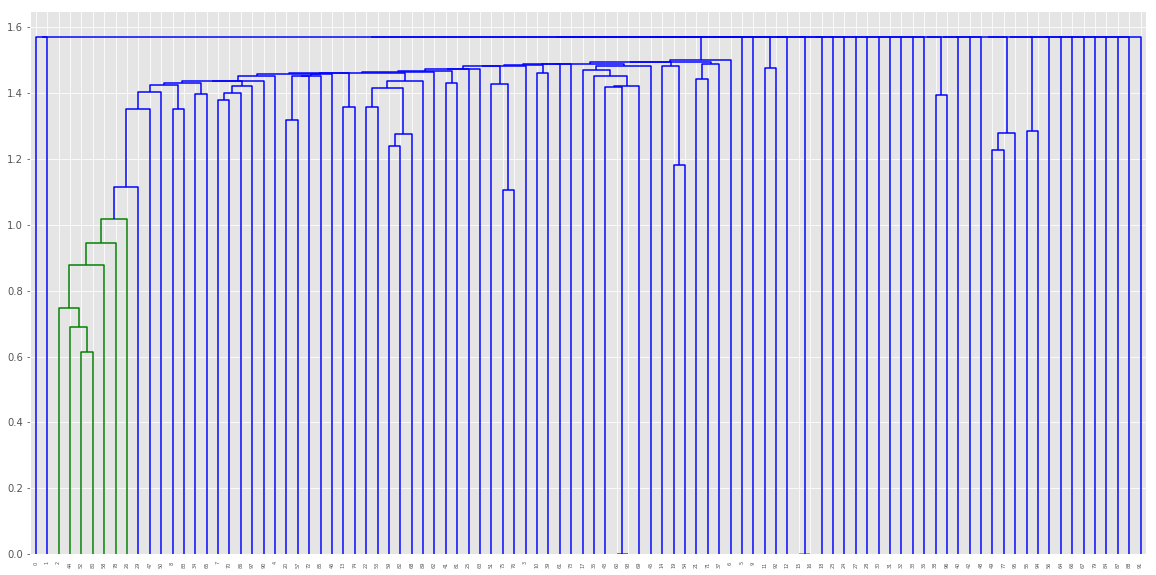

In [37]:
morph = pymorphy2.MorphAnalyzer()
vectorizer = TfidfVectorizer()

df = train_data[train_data.group_id == 3][['doc_id', 'target']]
X = make_vector(df.doc_id, doc_to_title, vectorizer)
myclf = Clustering('cosine','single', 2)
t = myclf.fit_predict(X)
cl = myclf.cut_tree(1.1)
k = len(cl)
for j in range(k):
    if cl[j] < k :
        cl[j] = 0
    else:
        cl[j] = 1
print('f1_score =', smt.f1_score(df.target, cl))
results = pd.DataFrame({
    'target': df.target,
    'predict': cl
})
pd.set_option('display.max_rows', 100)
myclf.plot_dendrogram()
results

f1_score = 0.5263157894736842


,target,predict
196,0,0
197,0,0
198,1,1
199,0,0
200,0,0
201,0,0
202,0,0
203,0,0
204,0,0
205,0,0


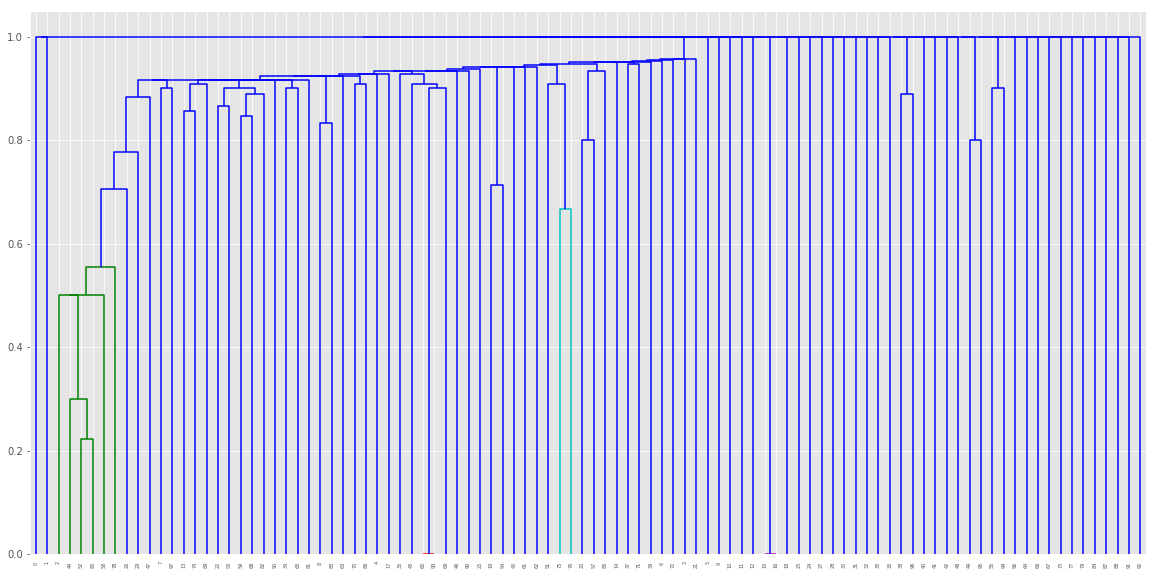

In [90]:
morph = pymorphy2.MorphAnalyzer()
vectorizer = TfidfVectorizer()

df = train_data[train_data.group_id == 3][['doc_id', 'target']]
X = make_sentence_vectors(df.doc_id, doc_to_title, vectorizer)
myclf = Clustering('number_of_words', 'single', 2)
t = myclf.fit_predict(X)
cl = myclf.cut_tree(0.6)
k = len(cl)
for j in range(k):
    if cl[j] < k:
        cl[j] = 0
    else:
        cl[j] = 1
print('f1_score =', smt.f1_score(df.target, cl))
results = pd.DataFrame({
    'target': df.target,
    'predict': cl
})
pd.set_option('display.max_rows', 100)
myclf.plot_dendrogram()
results


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ответ 1***

Кластеризацию стоит применять на тех данных, где мы не знаем связи класс - элемент(target). Например, у нас есть выборка документов, мы должны кластеризовать их по общим темам.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ответ 2***

***1) kmeans***

Преимущетсва:
    1) Можно добавлять данные в train
    2) Быстро сходится
    3) по fit мы можем предсказать кластера для новых объектов
    
Недостатки:
    1) Чувствителен к выбросам
    2) Число кластеров задается руками
    
**2) dbscan**

Преимущества:
    1) Сам определяет число кластеров
    2) Можно предсказывать на новых объектах
    3) Находит выбросы
    
Недостатки:
    1) Нельзя дообучать
    2) Нужно заранее подбирать параметры, задающие окрестность точки
    3) Не работает, если кластера разной плотности

**3) агломеративная кластеризация**

Преимущества:
    1) Выдает любое число кластеров
    2) Удобно и просто анализировать данные с помощью дендрограммы, в частности, находить выбросы
    3) Простой алгоритм
    
Недостатки:
    1) Нельзя добавлять ни train, ни test, так как придется перестраивать дерево полностью
    2) Алгоритм работает довольно-таки долго
   

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ответ 3***

Честно говоря, я затрудняюсь ответить на этот вопрос. Возможно тогда, когда функция плотности вероятности имеет какой-нибудь кривой вид, т.е. не нормально распределена.

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ответ 4***

Конечно, для этой задачи отлично бы подошли алгоритмы кластеризации, да и по факту, больше мы ничего использовать и не можем(ну разве что глазки), так как у нас нет учителя. Я бы сначала прогнал данные через агломеративную кластеризацию, нашел бы выбросы, удалил их, и после прогнал данные через kmeans.

Насчет признаков я бы сделал так: взял все документы, распарсил, посчитал tf-idf для каждого слова, так как размерность словарь слишком велика, чтобы брать вектор такой же размерности, что и словарь, стоило, наверное, взять, 1000 - 2000 слов, у которых tf-idf самый высокий. Это и был бы шаблон для вектора. Далее я посчитал бы вектор каждого документа. И все, в принципе расстояние готово - можно запускать алгоритм.

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ответ 5***

Я думаю, да. По-моему мнению, главнае проблема kmeans состоит в том, что мы не знаем на сколько кластеров делить нашу выборку. А если у нас уже есть размеченная выборка, то у нас есть количество кластеров(k) в ней, тогда мы можем пробежаться от 1 до k, запустить kmeans для каждого k и посмотреть наилучший скор.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

***Эта домашняя работа, конечно, значительно сложнее, чем прошлая, по крайней мере, по моим ощущениям и времени, которое я на нее потратил. Но код становится писать проще с каждым разом и понимание алгоритмов тоже улучшается, надеюсь, это развитие :). И вроде приходит осознание, что мы занимаемся действительно крутыми вещами, поэтому в целом все отлично***